# Importaciones de bibliotecas
En este fragmento de código, se importan varias bibliotecas esenciales para el análisis de datos y la visualización en Python:

- `pandas`: Utilizada para la manipulación y análisis de datos. Ofrece estructuras de datos y operaciones para manipular tablas numéricas y series temporales.
- `numpy`: Aporta soporte para arrays y matrices grandes y multidimensionales, junto con una colección de funciones matemáticas para operar con estas estructuras de datos.
- `matplotlib.pyplot`: Proporciona una manera de visualizar datos. Se usa comúnmente para crear gráficos y visualizaciones estáticas, animadas e interactivas.
- `seaborn`: Basada en matplotlib, esta biblioteca proporciona una interfaz de alto nivel para la creación de gráficos estadísticos atractivos y más complejos de forma más sencilla.
- `scipy.stats.kstest`: Se utiliza para realizar la prueba de Kolmogorov-Smirnov, un test para comparar una muestra con una distribución de referencia o comparar dos muestras entre sí.
- `scipy.stats.mannwhitneyu`: Utilizada para realizar la prueba U de Mann-Whitney, una prueba no paramétrica para evaluar si dos muestras independientes provienen de la misma distribución.


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
from scipy.stats import mannwhitneyu

## Carga de datos

Se cargan los datos de la prueba del modelo final sobre WMAP 

In [42]:
data = pd.read_csv('../data/resultswmap_v2.csv',sep=';')


In [43]:
data

,name,media,std
0,0,1.000000,0.000000e+00
1,1,1.000000,0.000000e+00
2,2,1.000000,0.000000e+00
3,3,1.000000,0.000000e+00
4,4,1.000000,0.000000e+00
...,...,...,...
528,528,1.000000,0.000000e+00
529,529,1.000000,0.000000e+00
530,530,0.999997,1.914453e-05
531,531,1.000000,0.000000e+00


## División de dataframe

Se divide el dataframe en predicciones acertadas o predicciones erróneas, OK y KO respectivamente. Es importante tener en cuenta que todos los registros del dataset son de fuentes

In [45]:
data['OK'] = np.where(data.media > 0.5,1,0)

In [46]:
len(data.loc[data.OK == 1])/len(data)

0.9812382739212008

In [47]:
#Cambiamos los valores de OK por FN para 0 y TP para 1
data['OK'] = data['OK'].replace(0, 'FN')
data['OK'] = data['OK'].replace(1, 'TP')

## Distribución de incertidumbre por tipo de clasificación

En el siguiente gráfico se muestra como generalmente las predicciones erróneas tiene una mayor incertidumbre o std

C:\Users\danie\AppData\Local\Temp\ipykernel_4064\733895697.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\danie\AppData\Local\Temp\ipykernel_4064\733895697.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  boxplot = sns.boxplot(


UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

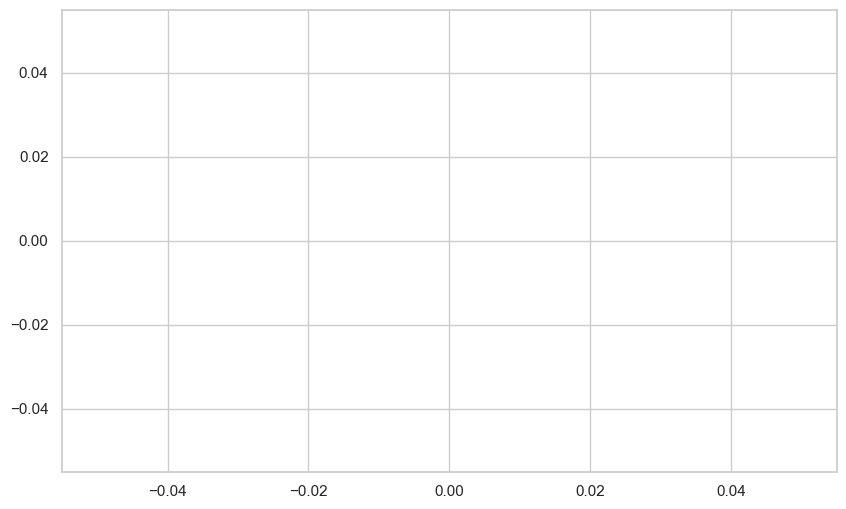

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de estilo y fuente
sns.set(style="whitegrid", font='Arial')

# Asignar nuevas etiquetas a las categorías
data['Classification'] = data['OK'].map({0: 'FN', 1: 'TP'})

# Crear una paleta de colores específica
palette = ["salmon", "cornflowerblue"]

# Crear el boxplot
plt.figure(figsize=(10, 6))  # Ajusta el tamaño del gráfico para mejor visualización
boxplot = sns.boxplot(
    x='Classification',  # Utiliza la nueva columna con las etiquetas 'FN' y 'TP'
    y='std', 
    data=data, 
    palette=palette,
    width=0.5,  # Ajusta el ancho de las cajas para un mejor aspecto
    linewidth=2,  # Grosor de las líneas de las cajas para mejor visualización
    fliersize=5  # Tamaño de los puntos de los outliers
)

# Añadir título y etiquetas con una fuente más formal y elegante
plt.title('Distribución de incertidumbre por FN y TP (N = 533)', fontsize=16, fontweight='bold')
plt.xlabel('Clasificación', fontsize=14)
plt.ylabel('Incertidumbre (std)', fontsize=14)

# Mostrar el gráfico
plt.show()


## Test de normalidad

Primero se comprueba si la std sigue una distribución normal, lo que determinará que tipó de test se realizará más adelante

In [50]:

data_KO = data.loc[data['OK'] == 'FN']
data_OK = data.loc[data['OK'] == 'TP']

In [52]:
#Hacemos un test de normalidad de Lilliefors para la std

#Hacemos test de Liliefors para ver si la distribucion de std es normal


print(f'OKs : {kstest(data_OK["std"], "norm")}')

print(f'KOs : {kstest(data_KO["std"], "norm")}')

OKs : KstestResult(statistic=0.5, pvalue=1.9823670827980797e-121, statistic_location=0.0, statistic_sign=-1)
KOs : KstestResult(statistic=0.500011166580733, pvalue=0.007775409398638459, statistic_location=2.7990467e-05, statistic_sign=-1)


## Test U de Mann-Whitney

Como la std no sigue una distribución normal se debe realizar una inferencia no parámetrica. Se ha optado por el Test U de Mann-Whitney para comprobar que las distribuciones de la std es diferente en los grupos OK y KO 

In [53]:

from scipy.stats import mannwhitneyu

#Hacemos el test de Mann-Whitney para ver si hay diferencias significativas entre las distribuciones de la std
#H0 = las dos distribuciones son iguales
#H1 = las dos distribuciones son diferentes 
if mannwhitneyu(data_KO['std'],data_OK['std']).pvalue < 0.05:
    print('La distribucion de std es diferente en los dos grupos')
    if mannwhitneyu(data_KO['std'],data_OK['std']).pvalue < 0.01:
        print('La diferencia es muy significativa')

    if mannwhitneyu(data_KO['std'],data_OK['std']).pvalue < 0.001:
        print('La diferencia es extremadamente significativa')
        if (data_KO['std'].mean() > data_OK['std'].mean()):
            print('La media de std es mayor en el grupo de KO')
        else:
            print('La media de std es mayor en el grupo de OK')
else:
    print('La distribucion de std es igual en los dos grupos')


La distribucion de std es diferente en los dos grupos
La diferencia es muy significativa
La diferencia es extremadamente significativa
La media de std es mayor en el grupo de KO


In [54]:
mannwhitneyu(data_KO['std'],data_OK['std']).pvalue

2.2815092542714795e-07